In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Loading and preparing the data 

In [36]:
df = pd.read_csv('stocks_combined_scaled.csv')

df.head()

,Unnamed: 0,date,permno,ticker,price,volume,return,high,low,open,avg_price,mkt_cap,pct_return,name_price_attention
0,0,2014-01-02,10107,MSFT,-0.999221,1.117934,-0.419196,-0.992613,-1.004799,-0.997672,-0.998750,0.138220,-0.419196,-0.712226
1,1,2014-01-03,10107,MSFT,-1.001527,1.148820,-0.421781,-0.994243,-1.009502,-0.999057,-1.001888,0.132557,-0.421781,-0.816796
2,2,2014-01-06,10107,MSFT,-1.008721,1.870624,-1.249333,-0.997232,-1.014112,-1.002286,-1.005672,0.114890,-1.249333,-0.771331
3,3,2014-01-07,10107,MSFT,-1.006139,1.417816,0.409965,-1.000854,-1.013171,-1.007130,-1.007056,0.121232,0.409965,-0.839528
4,4,2014-01-08,10107,MSFT,-1.012134,2.840056,-1.060843,-1.004023,-1.019098,-1.010129,-1.011579,0.106510,-1.060843,-0.807703


In [17]:
df1 = pd.read_csv("combined_financial_data.csv", index_col=0)
df1['daily_volatility'] = df1['price'] - df1['open']
df1.head()

,date,permno,ticker,price,volume,return,high,low,open,avg_price,mkt_cap,pct_return,name_price_attention,daily_volatility
0,2014-01-02,10107,MSFT,37.16,30423757.0,-0.006683,37.40,37.10,37.350,37.25,308428000.0,-0.6683,3.15,-0.190
1,2014-01-03,10107,MSFT,36.91,30944370.0,-0.006728,37.22,36.60,37.200,36.91,306353000.0,-0.6728,1.54,-0.290
2,2014-01-06,10107,MSFT,36.13,43111355.0,-0.021133,36.89,36.11,36.850,36.50,299879000.0,-2.1133,2.24,-0.720
3,2014-01-07,10107,MSFT,36.41,35478667.0,0.007750,36.49,36.21,36.325,36.35,302203000.0,0.7750,1.19,0.085
4,2014-01-08,10107,MSFT,35.76,59452427.0,-0.017852,36.14,35.58,36.000,35.86,296808000.0,-1.7852,1.68,-0.240


In [18]:
df_test = pd.read_csv("quarterly_financial_data_2013_2023.csv")


#df_test = df_test.rename(columns = {'datedate': 'date'})
df_test['date'] = df_test['datadate']
df_test['ticker'] = df_test['tic']
df_test.head()

,gvkey,datadate,fqtr,tic,conm,net_income,revenue,total_assets,shareholders_equity,total_liabilities,total_debt,sales,operating_activities_cf,capital_expenditures,interest_expense,common_shares_outstanding,earnings_per_share,dividends_per_share,date,ticker
0,1690,2013-03-31,2,AAPL,APPLE INC,9547.0,43603.0,194743.0,135490.0,59253.0,0.0,43603.0,35930.0,4325.0,0.0,940.094,10.16,2.65,2013-03-31,AAPL
1,1690,2013-06-30,3,AAPL,APPLE INC,6900.0,35323.0,199856.0,123354.0,76502.0,16958.0,35323.0,43758.0,6210.0,53.0,908.442,7.51,3.05,2013-06-30,AAPL
2,1690,2013-09-30,4,AAPL,APPLE INC,7512.0,37472.0,207000.0,123549.0,83451.0,16960.0,37472.0,53666.0,8165.0,83.0,899.213,8.31,3.05,2013-09-30,AAPL
3,1690,2013-12-31,1,AAPL,APPLE INC,13072.0,57594.0,225184.0,129684.0,95500.0,16961.0,57594.0,22670.0,1985.0,84.0,892.447,14.59,3.05,2013-12-31,AAPL
4,1690,2014-03-31,2,AAPL,APPLE INC,10223.0,45646.0,205989.0,120179.0,85810.0,16962.0,45646.0,36208.0,3367.0,85.0,861.745,11.69,3.05,2014-03-31,AAPL


In [19]:
anomalies_df = pd.merge(df, df_test[['date','ticker','revenue', 'total_assets', 'earnings_per_share']], on=['date', 'ticker'], how = 'left')
anomalies_df['book_to_market'] = anomalies_df['total_assets'] / anomalies_df['mkt_cap']
anomalies_df['dt_date'] = pd.to_datetime(anomalies_df['date'])
anomalies_df['jan_dummy'] = (anomalies_df['dt_date'].dt.month == 1).astype(int)
anomalies_df['jan_dummy'] = anomalies_df['jan_dummy'].fillna(0)
anomalies_df['monday_dummy'] = (anomalies_df['dt_date'].dt.dayofweek == 0).astype(int)
anomalies_df['monday_dummy'] = anomalies_df['monday_dummy'].fillna(0)
anomalies_df['annual_rep_release'] = anomalies_df['book_to_market'].notna().astype(int)
anomalies_df['annual_rep_release'] = anomalies_df['annual_rep_release'].fillna(0)
#anomalies_df[anomalies_df['book_to_market'].notna()].head()
anomalies_df.head()

,Unnamed: 0,date,permno,ticker,price,volume,return,high,low,open,...,pct_return,name_price_attention,revenue,total_assets,earnings_per_share,book_to_market,dt_date,jan_dummy,monday_dummy,annual_rep_release
0,0,2014-01-02,10107,MSFT,-0.999221,1.117934,-0.419196,-0.992613,-1.004799,-0.997672,...,-0.419196,-0.712226,NaN,NaN,NaN,NaN,2014-01-02,1,0,0
1,1,2014-01-03,10107,MSFT,-1.001527,1.148820,-0.421781,-0.994243,-1.009502,-0.999057,...,-0.421781,-0.816796,NaN,NaN,NaN,NaN,2014-01-03,1,0,0
2,2,2014-01-06,10107,MSFT,-1.008721,1.870624,-1.249333,-0.997232,-1.014112,-1.002286,...,-1.249333,-0.771331,NaN,NaN,NaN,NaN,2014-01-06,1,1,0
3,3,2014-01-07,10107,MSFT,-1.006139,1.417816,0.409965,-1.000854,-1.013171,-1.007130,...,0.409965,-0.839528,NaN,NaN,NaN,NaN,2014-01-07,1,0,0
4,4,2014-01-08,10107,MSFT,-1.012134,2.840056,-1.060843,-1.004023,-1.019098,-1.010129,...,-1.060843,-0.807703,NaN,NaN,NaN,NaN,2014-01-08,1,0,0


### Start with OLS and robust Regression (inspecting the relationships)

In [53]:
# splitting the data 
fix_seed = 42

y = df['return']
X = df[['name_price_attention']]
X1 = df[['name_price_attention']]
X2 = df[['name_price_attention', 'mkt_cap']]
X3 = df[['name_price_attention', 'daily_volatility']]
X4 = df[['name_price_attention', 'volume']]
X5 = df[['name_price_attention', 'mkt_cap', 'daily_volatility']]
X6 = df[['name_price_attention', 'mkt_cap', 'volume']]
X7 = df[['name_price_attention', 'volume', 'daily_volatility']]
X8 = df[['name_price_attention', 'mkt_cap', 'volume', 'daily_volatility']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=fix_seed)

KeyError: "['daily_volatility'] not in index"

In [31]:
# create OLS regression for y and X
X_train = sm.add_constant(X_train)  
model = sm.OLS(y_train, X_train)
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.525
Date:                Mon, 04 Mar 2024   Prob (F-statistic):              0.112
Time:                        16:52:58   Log-Likelihood:                -79957.
No. Observations:               56358   AIC:                         1.599e+05
Df Residuals:                   56356   BIC:                         1.599e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0031 

'HC0': Original White's (1980) heteroskedasticity robust standard errors.

'HC1': MacKinnon and White's (1985) alternative heteroskedasticity robust standard errors.

'HC2': Another heteroskedasticity robust standard error estimator.

'HC3': The recommended heteroskedasticity robust standard error estimator that has superior small-sample properties.

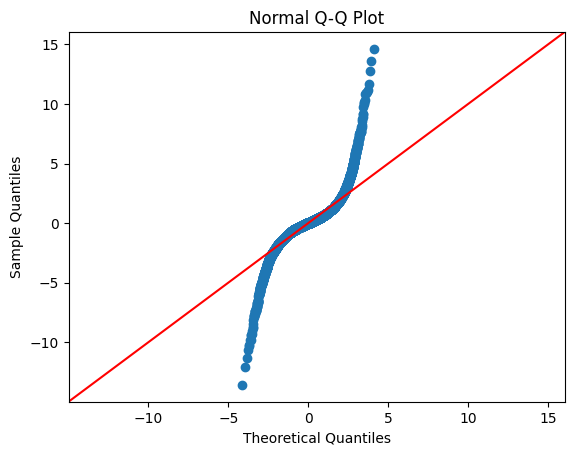

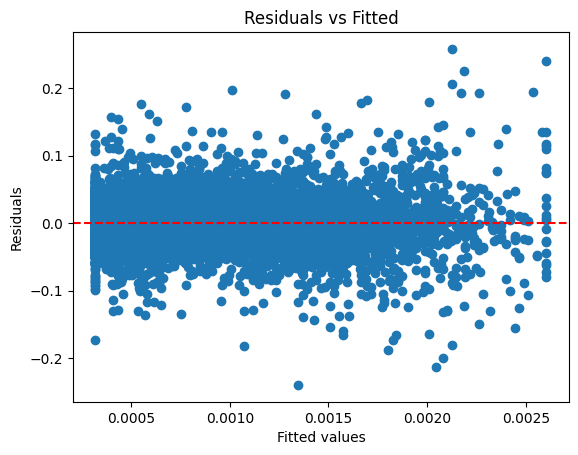

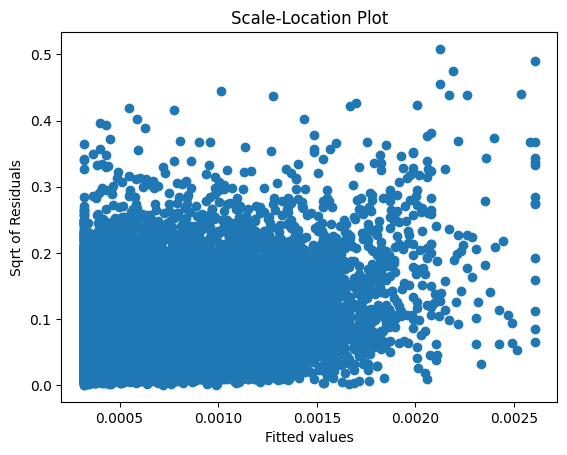

KeyboardInterrupt: 

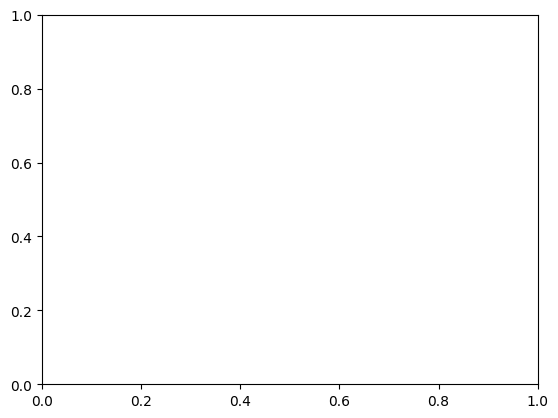

In [8]:
# QQ plot for normality of residuals
fig = sm.qqplot(results.resid, line='45', fit=True)
plt.title('Normal Q-Q Plot')
plt.show()

# Residuals vs Fitted for homoscedasticity
plt.scatter(results.fittedvalues, results.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Scale-Location plot (also called Spread-Location plot)
plt.scatter(results.fittedvalues, results.resid**0.5)
plt.xlabel('Fitted values')
plt.ylabel('Sqrt of Residuals')
plt.title('Scale-Location Plot')
plt.show()

# Leverage plot to find influential cases
sm.graphics.influence_plot(results, criterion="cooks")
plt.title('Influence Plot')
plt.show()

Given these results we will use a robust regression which does not have these assumptions. 

In [54]:
# create numpy arrays for each feature combination to later call in the OLS and robust regression 
y = df['return']
X1 = df[['name_price_attention']]
X2 = df[['name_price_attention', 'mkt_cap']]
#X3 = df[['name_price_attention', 'daily_volatility']]
X4 = df[['name_price_attention', 'volume']]
#X5 = df[['name_price_attention', 'mkt_cap', 'daily_volatility']]
X6 = df[['name_price_attention', 'mkt_cap', 'volume']]
#X7 = df[['name_price_attention', 'volume', 'daily_volatility']]
#X8 = df[['name_price_attention', 'mkt_cap', 'volume', 'daily_volatility']]

In [34]:
# create a robust regression for each feature combination
X1= sm.add_constant(X1)
model1 = sm.RLM(y, X1, M=sm.robust.norms.HuberT())
results1 = model1.fit()
print(results1.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                70448
Model:                            RLM   Df Residuals:                    70446
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 04 Mar 2024                                         
Time:                        16:53:47                                         
No. Iterations:                    21                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0039 

In [37]:
X = sm.add_constant(X2)
model2 = sm.RLM(y, X, M=sm.robust.norms.HuberT())
results2 = model2.fit()
print(results2.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                70448
Model:                            RLM   Df Residuals:                    70445
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 04 Mar 2024                                         
Time:                        17:13:19                                         
No. Iterations:                    21                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0039 

In [ ]:
X3 = sm.add_constant(X3)
model3 = sm.RLM(y, X3, M=sm.robust.norms.HuberT())
results3 = model3.fit()
print(results3.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:             pct_return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64005
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        19:23:34                                         
No. Iterations:                    39                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0394 

In [38]:
X4 = sm.add_constant(X4)
model4 = sm.RLM(y, X4, M=sm.robust.norms.HuberT())
results4 = model4.fit()
print(results4.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                70448
Model:                            RLM   Df Residuals:                    70445
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 04 Mar 2024                                         
Time:                        17:13:45                                         
No. Iterations:                    24                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0024 

In [ ]:
X5 = sm.add_constant(X5)
model5 = sm.RLM(y, X5, M=sm.robust.norms.HuberT())
results5 = model5.fit()
print(results5.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:             pct_return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64004
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        19:23:35                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0415 

In [39]:
X6 = sm.add_constant(X6)
model6 = sm.RLM(y, X6, M=sm.robust.norms.HuberT())
results6 = model6.fit()
print(results6.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                70448
Model:                            RLM   Df Residuals:                    70444
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 04 Mar 2024                                         
Time:                        17:13:54                                         
No. Iterations:                    28                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0011 

In [ ]:
X7 = sm.add_constant(X7)
model7 = sm.RLM(y, X7, M=sm.robust.norms.HuberT())
results7 = model7.fit()
print(results7.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:             pct_return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64004
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        19:23:36                                         
No. Iterations:                    46                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0530 

In [ ]:
X8 = sm.add_constant(X8)
model8 = sm.RLM(y, X8, M=sm.robust.norms.HuberT())
results8 = model8.fit()
print(results8.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:             pct_return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64003
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        19:23:37                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0493 

In [44]:
from statsmodels.iolib.summary2 import summary_col

# Assuming results1 to results8 are the fitted model results
results_list = [results1, results2, results4,  results6 ]

# results3
# results5
#results7, results8

# Create the regression table
regression_table = summary_col(results_list,
                               stars=True,
                               model_names=[
                                   'Model 1', 'Model 2', #'Model 3',
                                   'Model 4', #'Model 5', 
                                   'Model 6', #'Model 7', 'Model 8'
                               ],
                               float_format="%0.2f",
                               info_dict={'N': lambda x: f"{int(x.nobs)}", 'R2': lambda x: f"{x.rsquared:.2f}"})

print(regression_table)

# input layer 784 weil wir 28x28 pixel haben
# man fügt layers hinzu bis der error nicht mehr kleiner wird 
# anschliessend layers kleiner machen bis der error wieder schlechter wird. val_error beobachten, um zu schauen, dass er nicht mehr steigt. 
# schauen ob in der selben epoche der val_error kleiner wird.
# batch size: 
# 
# Goal: best accuracy with lowest computational cost



                     Model 1 Model 2 Model 4  Model 6 
------------------------------------------------------
const                0.00    0.00    0.00     0.00    
                     (0.00)  (0.00)  (0.00)   (0.00)  
name_price_attention 0.02*** 0.02*** 0.02***  0.02*** 
                     (0.00)  (0.00)  (0.00)   (0.00)  
mkt_cap                      0.01***          0.02*** 
                             (0.00)           (0.00)  
volume                               -0.02*** -0.03***
                                     (0.00)   (0.00)  
N                    70448   70448   70448    70448   
R2                                                    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


### Fixed effects

In fixed effects (FE) models, the individual-specific effect is treated as a parameter to be estimated, not as a random variable. This effect captures all unobserved heterogeneity between individuals (or entities, such as firms, countries, etc.).
Each individual (or entity) has its own intercept term. Essentially, the model includes a dummy variable for each individual (less one to avoid the dummy variable trap), which controls for all time-invariant characteristics of the individuals.
Because of this, fixed effects models can only include time-varying covariates. Time-invariant covariates are perfectly collinear with the individual dummies and thus cannot be estimated.
Fixed effects models are used when the focus is on analyzing the impact of variables that vary within an individual over time, and there is a concern that omitted time-invariant characteristics could bias the results.

In [49]:
# add a column stock_dummy dummy variable for each stock 
anomalies_df['stock_dummy'] = anomalies_df['ticker'].astype('category').cat.codes

In [56]:
import statsmodels.api as sm
import pandas as pd

# Assuming you have a DataFrame 'df' with the following columns:
# 'entity' - your fixed effects groups (e.g., individuals, firms, etc.)
# 'time' - your time variable, if you also want to control for time fixed effects
# 'y' - your dependent variable
# 'X' - your independent variables

# Create dummy variables for each entity
#entity_dummies = pd.get_dummies(df['entity'], drop_first=True)
#time_dummies = pd.get_dummies(df['time'], drop_first=True)  # If you also want time fixed effects


X = anomalies_df[['name_price_attention', 'stock_dummy']]

# Add a constant to the independent variables
X = sm.add_constant(X)

# Create the RLM model with robust standard errors
rlm_model = sm.RLM(y, X, M=sm.robust.norms.HuberT())

# Fit the model
results = rlm_model.fit()  # Use 'H1' for robust covariance matrix

# Print the results
print(results.summary())


                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                70448
Model:                            RLM   Df Residuals:                    70445
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 04 Mar 2024                                         
Time:                        17:44:22                                         
No. Iterations:                    22                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0060 

### including Anomalies 

In [35]:
X9 = anomalies_df[['name_price_attention', 'mkt_cap', 'volume', 'daily_volatility', 'jan_dummy']]
X9_5 = anomalies_df[['mkt_cap', 'volume', 'daily_volatility', 'jan_dummy']]
X10 = anomalies_df[['name_price_attention', 'mkt_cap', 'volume', 'daily_volatility', 'monday_dummy']]
X10_5 = anomalies_df[['mkt_cap', 'volume', 'daily_volatility', 'monday_dummy']]
X11 = anomalies_df[['name_price_attention', 'mkt_cap', 'volume', 'daily_volatility', 'annual_rep_release']]
X11_5 = anomalies_df[[ 'mkt_cap', 'volume', 'daily_volatility', 'annual_rep_release']]
X12 = anomalies_df[['name_price_attention', 'mkt_cap', 'volume', 'daily_volatility', 'annual_rep_release', 'monday_dummy', 'jan_dummy']]
X12_5 = anomalies_df[['mkt_cap', 'volume', 'daily_volatility', 'annual_rep_release', 'monday_dummy', 'jan_dummy']]

KeyError: "['daily_volatility'] not in index"

In [ ]:
X9 = sm.add_constant(X9)
model9 = sm.RLM(y, X9, M=sm.robust.norms.HuberT())
results9 = model9.fit()
print(results9.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64002
Method:                          IRLS   Df Model:                            5
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        18:00:12                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [ ]:
X10 = sm.add_constant(X10)
model10 = sm.RLM(y, X10, M=sm.robust.norms.HuberT())
results10 = model10.fit()
print(results10.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64002
Method:                          IRLS   Df Model:                            5
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        18:00:20                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [ ]:
X11 = sm.add_constant(X11)
model11 = sm.RLM(y, X11, M=sm.robust.norms.HuberT())
results11 = model11.fit()
print(results11.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64002
Method:                          IRLS   Df Model:                            5
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        18:00:30                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0005 

In [ ]:
X12 = sm.add_constant(X12)
model12 = sm.RLM(y, X12, M=sm.robust.norms.HuberT())
results12 = model12.fit()
print(results12.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 return   No. Observations:                64008
Model:                            RLM   Df Residuals:                    64000
Method:                          IRLS   Df Model:                            7
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        18:02:55                                         
No. Iterations:                    50                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0006 

### Gradient Boost Regressor (ML) 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

In [ ]:
#splitting the data

fix_seed = 32
#X = df['name_price_attention']  # Extracting the feature
X = anomalies_df[['name_price_attention', 'mkt_cap', 'volume', 'daily_volatility', 'annual_rep_release', 'monday_dummy', 'jan_dummy']] #subject to change based on Robust regression
y = anomalies_df['pct_return']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=fix_seed)

In [ ]:
params = {
    "n_estimators": 100,
    #"max_depth": 10,
    #"min_samples_split": 5,
    "learning_rate": 0.1,
    #"loss": "squared_error",
} #run a grid search maybe?

gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=fix_seed)
gb_regressor.fit(X_train, y_train)

GradientBoostingRegressor(random_state=32)

In [ ]:
y_pred = gb_regressor.predict(X_test)

# Evaluate the model
mse1 = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse1)

Mean Squared Error: 1.2786028641423457


In [ ]:
feature_importances = gb_regressor.feature_importances_

# Get column names of your features
feature_names = X_train.columns

# Create a dictionary to map feature names to their importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the dictionary by importance values (optional)
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print or access the feature importances
for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: daily_volatility, Importance: 0.8621784822251249
Feature: volume, Importance: 0.05406277589976735
Feature: mkt_cap, Importance: 0.04731910959376765
Feature: name_price_attention, Importance: 0.03347539787089543
Feature: monday_dummy, Importance: 0.002869527359730615
Feature: jan_dummy, Importance: 9.470705071399751e-05
Feature: annual_rep_release, Importance: 0.0


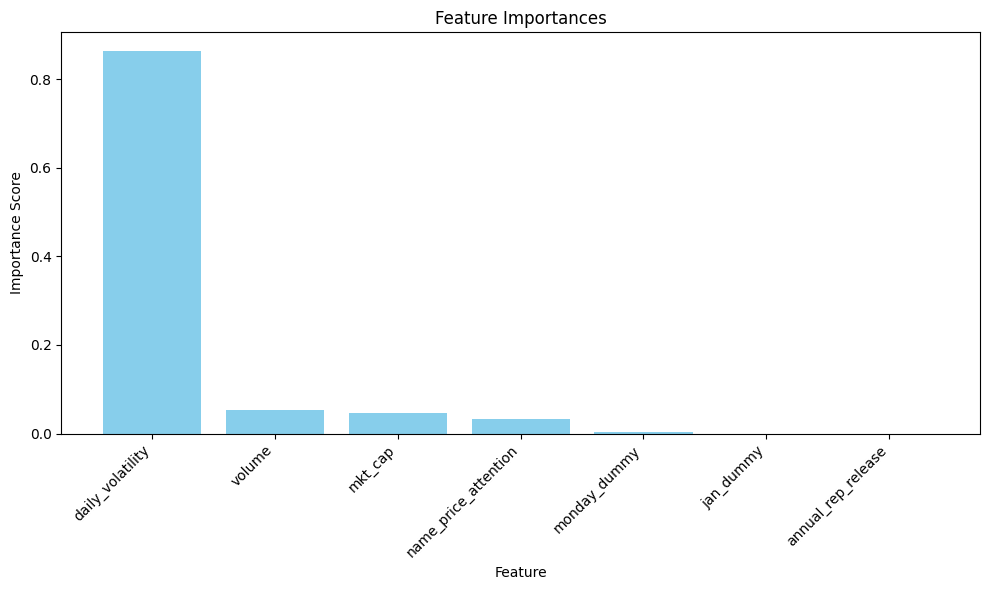

In [ ]:
sorted_features = [x[0] for x in sorted_feature_importance]
sorted_importances = [x[1] for x in sorted_feature_importance]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_features)), sorted_importances, color="skyblue", align="center")
plt.xticks(range(len(sorted_features)), sorted_features, rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

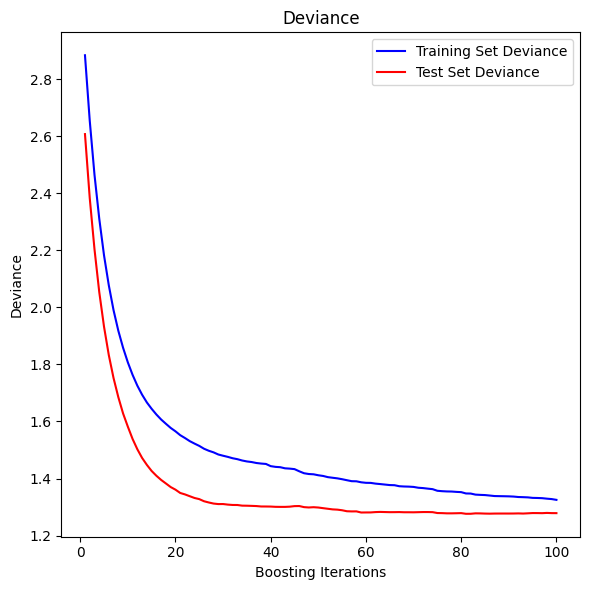

In [ ]:
# Visualization 

test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(gb_regressor.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    gb_regressor.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

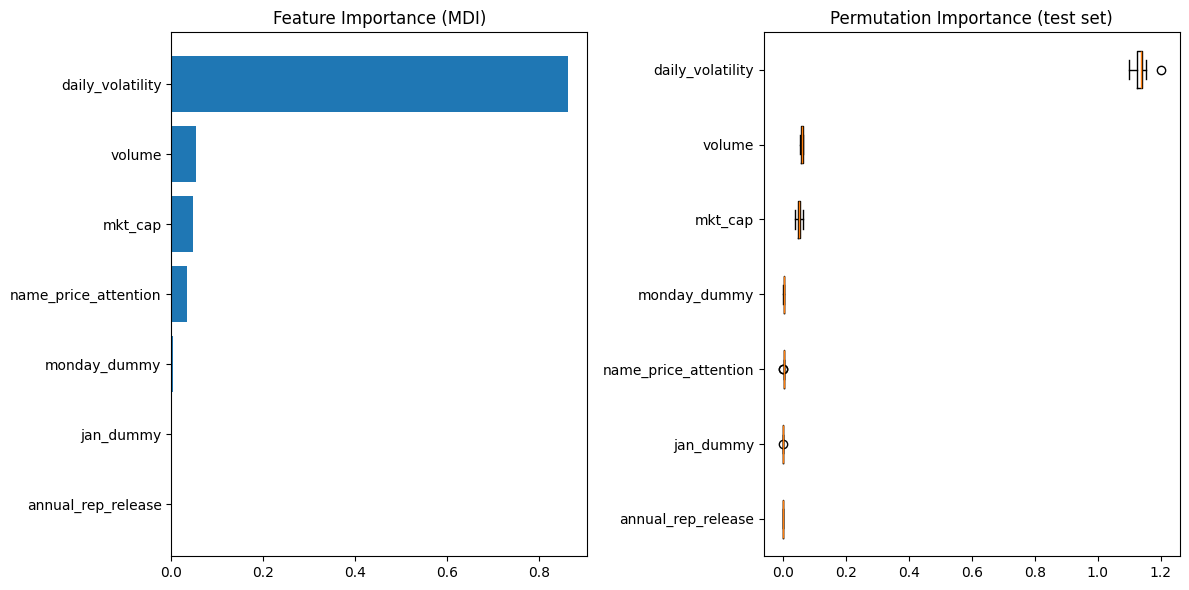

In [ ]:
feature_importance = gb_regressor.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    gb_regressor, X_test, y_test, n_repeats=10, random_state=fix_seed, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [ ]:
# rescaling 
# log mkt and volume 
